# Tree-Based Model


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Helper Function

In [8]:
def sort_xcat_by_y(x, y):
    """
    return a sorted list of unique categories in predictor x according to y
    """
    cats = np.unique(x)
    y_mean = [ np.mean(y[x==cat]) for cat in cats ]
    ordered_cats = cats[np.argsort(y_mean)]
    return ordered_cats

def all_rows_equal(X):
    """
    check if all of a bud's rows are equal across all predictors
    """
    return np.all(X == X[0])


In [9]:
class Node:
    def __init__(self, X, y, id, parent_id=None, depth=0,leaf=True):
        self.X = X # sample in this node
        self.y = y # target in this node
        self.size = len(y)
        self.id = id
  
        self.parent_id = parent_id
        self.depth = depth
        self.leaf = leaf

        self.child_L = None
        self.child_R = None

class Splitter:
    def __init__(self):
        self.reduction = 0
        self.splitted = False
        
    def _replace_split(self, reduction, d, dtype='q', t=None, c=None):
        self.reduction = reduction
        self.d = d
        self.dtype = dtype
        self.t = t # threshold for qulitative
        self.c = c # threshold for qutitative
        self.splitted = True


# Loss Function

In [ ]:
def RSS_reduction(child_L, child_R, parent):
    """
    cost function: how much the residual is reduced
    """
    rss_p = np.sum((parent - np.mean(parent))^2)
    rss_l = np.sum((child_L - np.mean(child_L))^2)
    rss_r = np.sum((child_R - np.mean(child_R))^2)
    return rss_p - rss_l - rss_r


# RegressionTree

In [10]:
class DecisionTreeRegression:
    def fit(self, X, y, max_depth=100, min_size=5):
        self.X = X
        self.y = y

        self.N, self.D = X.shape
        dtypes = [ np.array(X[:, i]).dtype for i in range(self.D) ]
        # What about boolean?
        self.types = [ 'q' if (dtype == float or dtype == int) else 'c' for dtype in dtypes ]

        # hyperparameters
        self.max_depth = max_depth
        self.min_size = min_size
        
        # initialize
        self.nodes_dict = {} # record all nodes in the tree
        self.current_id = 0
        root = Node(X, y, self.current_id) # init root node
        self.nodes_dict[self.current_id] = root
        self.current_id += 1
        
    def _build_(self):
        """
        loop each observation of each feature in each layerZA
        """
        
        for i in range(self.max_depth): #  each layer        
            # which node can be splitted?
            eligible_buds = {ID: node for (ID, node) in self.nodes_dict.items() if
                             node.leaf==True and
                             node.size > self.min_size 
                             # and sth??
                            }
            if len(eligible_buds) == 0:
                break

            for dnode in eligible_buds: # each node in this layer
                splitter = Splitter()
                
                # todo: randomly select C features at each split for random forest
                # np.random.choice(np.arange(self.D), self.C, replace = False)

                for d in range(self.D): # loop each feature
                    # info about this feature
                    xd = dnode.X[:, d]
                    dty = self.types[d]
                    
                    if np.unique(xd) == 1:
                        continue

                    # each threshold for this feature
                    # quantitative
                    if dty == 'q':
                        for v in np.unique(xd)[:-1]: # sort the value in an ascending way
                            yl = self.y[xd <= v] # left tree
                            yr = self.y[xd > v] # right tree
                            reduction = RSS_reduction(yl, yr, dnode.y)
                            if reduction > splitter.reduction:
                                splitter._replace_split(reduction, d, 'q', v)

                    # categorical
                    if dty == 'c':
                        pass

                # then make split for each node

    def predict(self, X_test):
        y_predicted = []
        for x in X_test:
            node = self.node_dict[0] # start from the root node
            while not node.leaf:
                if node.dtype == 'q':
                    if x[node.d] < node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
           
            y_predicted.append(np.mean(node.y))
        return y_predicted


# Bagging

In [6]:
class Bagging:
    def bootstrapping(self, X_train, y_train, B):
        self.N, self.D = X_train.shape
        self.B = B

        trees = []
        for i in range(B):
            idx = np.random.choice(range(self.N), self.N, replace=True)
            X_train_sample = X_train[idx]
            y_train_sample = y_train[idx]

            tree = DecisionTreeRegression()
            tree.fit(X_train_sample, y_train_sample)
            trees.append(tree)

        self.trees = trees

    def predict(self, X_test):
        y_predicted = np.zeros((self.B, len(X_test))) # B by N
        
        for i in range(self.B):
            y_predicted[i, :] = self.trees[i].predcit(X_test)

        # return average value of all trees for each observation
        return np.mean(y_predicted, axis=0)


# Boosting

In [9]:

from fastai.imports import *
from sklearn import metrics


In [14]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)


class DecisionTree:
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)
    

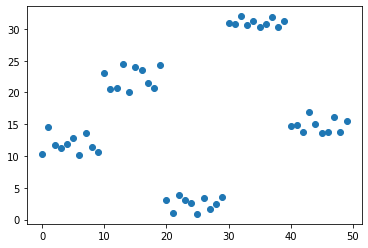

In [36]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

plt.scatter(x, y)


n: 50; val:16.50505755221116; score:407.8007173466392; split:29; var:x
n: 50; val:1.9539925233402757e-15; score:326.92332579474134; split:39; var:x
n: 50; val:1.4210854715202004e-16; score:308.22793211992405; split:29; var:x
n: 50; val:2.1316282072803005e-16; score:266.5642750471887; split:19; var:x


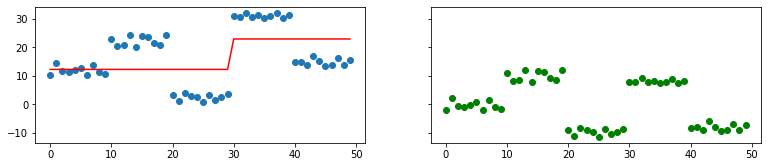

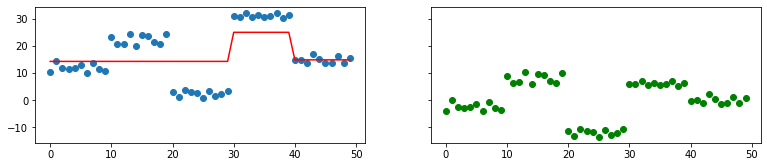

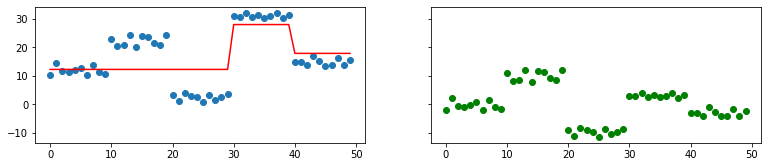

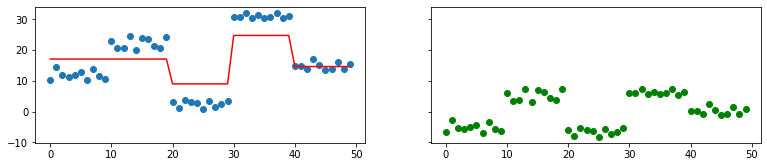

In [41]:
xi = x
yi = y
n = len(yi)
predf = 0 # initial prediction
ei = 0

for i in range(4):
    tree = DecisionTree(xi, yi)
    tree.find_better_split(0)
    print(tree)
    
    r = np.where(xi == tree.split)[0][0]  
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]

    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n - r))

    predi = predi[:, None] # make long vector (nx1) in compatible with y
    predf = predf + predi # # final prediction = previous prediction value + new prediction of residual

    ei = y - predf
    yi = ei # update yi as residual to reloop
    
    
    
    xa = np.array(x.x) # column name of x is x
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    # plot
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))
    ax1.plot(x, y, 'o')
    ax1.plot(xs, ys, 'r')
    
    ax2.plot(x, ei, 'go')
    
    